##Implement complete autograd framework in python and numpy  and mnist classifier using the autograd framework.

Reference : grokking deep learning book and samples in github  - Please use this as example and implement from scratch. write unittests for your code.

https://github.com/iamtrask/Grokking-Deep-Learning/blob/master/Chapter13%20-%20Intro%20to%20Automatic%20Differentiation%20-%20Let's%20Build%20A%20Deep%20Learning%20Framework.ipynb (Links to an external site.)



In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

##Creating Tensor Object

In [3]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    


##Defining Linear Layer 

In [4]:
class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))

#Sequential Layers-Adding on the layers

In [5]:
class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params

##Defining Non Linear Layers

In [6]:
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

class Relu(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.relu()



    

## Defining Loss Function-MSE and Cross Entropy

In [7]:
class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

In [8]:
class MSELoss(Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        return ((pred - target)*(pred - target)).sum(0)

# Stochastic Gradient Descent Optimizer

In [9]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

#Unit Tests

In [10]:
a = Tensor([1,2,3,4,5], autograd=True)
b = Tensor([2,2,2,2,2], autograd=True)
c = Tensor([5,4,3,2,1], autograd=True)

d = a + b
e = b + c
f = d + e

f.backward(Tensor(np.array([1,1,1,1,1])))

print(b.grad.data == np.array([2,2,2,2,2]))

[ True  True  True  True  True]


In [11]:
x = Tensor(np.array([[1,2,3],
                     [4,5,6]]))

In [12]:
x.sum(0)

array([5, 7, 9])

In [13]:
x.sum(1)

array([ 6, 15])

In [14]:
x.expand(dim=2, copies=4)

array([[[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3]],

       [[4, 4, 4, 4],
        [5, 5, 5, 5],
        [6, 6, 6, 6]]])

###Loading MNIST Dataset

In [15]:
#Splitting dataset into train and test dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [16]:
x_train.shape

(60000, 28, 28)

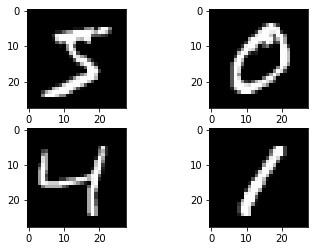

(28, 28)


In [17]:
# Looking at how the data looks
plt.subplot(221)
plt.imshow(x_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(x_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(x_train[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()
print(x_train[0].shape)

In [18]:
num_pixels = x_train.shape[1] * x_train.shape[2]
print(num_pixels)

784


In [19]:
#Reshaping the images
x_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
x_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')



In [20]:
# Normalizing Images
x_train = x_train/255
x_test = x_test/255

In [21]:
# Label Encoding 
labels=y_train
train_labels = np.zeros((len(labels),10))
for i,l in enumerate(y_train):
    train_labels[i][l] = 1
labels = train_labels

test_labels = np.zeros((len(y_test),10))
for i,l in enumerate(y_test):
    test_labels[i][l] = 1

In [22]:
test_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [23]:
print(f'Train Data: {x_train.shape}, Train Label: {labels.shape}, Test Data: {x_test.shape}, Test Label: {test_labels.shape}')

Train Data: (60000, 784), Train Label: (60000, 10), Test Data: (10000, 784), Test Label: (10000, 10)


In [24]:
def mini_batch(x, y):
  y_pred = model.forward(x)
  loss = criterion.forward(y_pred, y)
  loss.backward()
  optim.step()
  return model, loss

In [25]:
#training the model
data = Tensor(x_train, autograd=True) # converting x_train dataset to tensor
target = Tensor(labels, autograd=True)# converting y_train (Labels) dataset to tensor

model = Sequential([Linear(784,200), Tanh() ,Linear(200,80), Tanh(), Linear(80,10), Sigmoid()]) # Creating model with 3 layers--->2 layers with Tanh and output layer with Sigmoid Non Linearity
criterion = MSELoss()

optim = SGD(parameters=model.get_parameters(), alpha=0.001)
batch_size = 256
for epoch in range(200):
    for i in range(int(len(data.data)/batch_size)):
      batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))
      x=Tensor(data.data[batch_start:batch_end],autograd=True)
      y=Tensor(target.data[batch_start:batch_end],autograd=True)
      model, loss = mini_batch(x,y)

    if epoch % 25 == 0:
        pred = model.forward(data)
        train_correct = (np.argmax(target.data,axis=1) == np.argmax(pred.data,axis=1)).mean()
        print("Train Accuracy:",train_correct,"Train Loss:", (loss.sum(0).data)/len(data.data))


Train Accuracy: 0.89945 Train Loss: 0.0006353037599890535
Train Accuracy: 0.9832333333333333 Train Loss: 0.00025437837699005173
Train Accuracy: 0.9919 Train Loss: 0.00020971524979527617
Train Accuracy: 0.9953333333333333 Train Loss: 0.00015219613273165624
Train Accuracy: 0.99655 Train Loss: 0.00010516833667822597
Train Accuracy: 0.9972 Train Loss: 9.378838694534868e-05
Train Accuracy: 0.9976833333333334 Train Loss: 9.030368482406758e-05
Train Accuracy: 0.9979 Train Loss: 8.809584614376037e-05


In [26]:
#prediction 
X_test=Tensor(x_test,autograd=True)
y_pred = model.forward(X_test) 
Y_pred = np.argmax(y_pred.data, 1)
print(Y_pred.data)
#y_test = np.argmax(y_test.data, 1) 

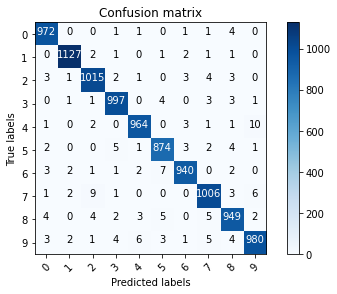

In [27]:
# Confusion matrix 
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [35]:
test_correct = (y_test == Y_pred).mean()
print("Test Accuracy:", test_correct)

Test Accuracy: 0.9824


In [34]:
Y_pred

array([7, 2, 1, ..., 4, 5, 6])